# HW 5
## Tim Demetriades
### AAI 695 WS2 - Shucheng Yu
4/27/2022

#### Question 5 - Programming 
#### Design a genetic algorithm to solve the polynomial fitting problem that we did in Homework #1. You need to implement a genetic algorithm using BOTH mutation AND crossover operations. You need to decide a mutation rate and a crossover rate.  

#### Plot the following in one figure: 1) the original noisy data, 2) the polynomial you obtained in Homework  #1,  and  3)  the  polynomial  obtained  from  this  implementation.  Compare  and discussion the difference in performance of the two polynomials obtained with two different methods. 

### 1) The original noisy data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import mean_squared_error

In [2]:
plt.style.use('seaborn-whitegrid')

In [3]:
noise_scale = 100
num_of_samples = 50

x = 25 * (np.random.rand(num_of_samples, 1) - 0.8)    # 50 x 1 vector
x.sort(axis = 0)    # needed for graphs
y = 7 * x + 15 * x ** 2 + 1 * x ** 3 + noise_scale * np.random.randn(num_of_samples, 1)    # y = 7x + 15x^2 + x^3 + noise

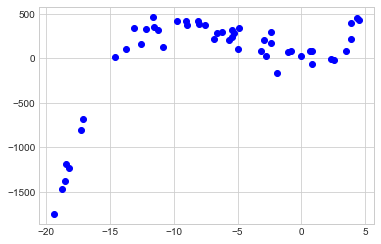

In [4]:
plt.plot(x, y, 'bo')

### 2) The polynomial obtained in HW 1

In [5]:
m = 6    # degree of polynomial

In [41]:
def fit_polynomial(x, y, m):
    # x is the x-values
    # y is the y-values
    # m is the order of the poly
    
    poly_coef = np.polyfit(x.flatten(), y.flatten(), m).reshape(m + 1, 1)
    poly_base = np.array([x ** i for i in range(m, -1, -1)])[:, :, 0]

    poly_eqn = np.sum(poly_base * poly_coef, axis=0)
    poly_eqn = np.expand_dims(poly_eqn, axis=1)
    
    return poly_eqn

The below function will be used to calculate the mean squared error and will also be used as the evaluation function for the genetic algorithm to determine the badness of each chromosome array.

In [8]:
def evaluate(y_actual, y_pred):
    # y_actual is the actual y-values
    # y_pred is the predicted y-values from the poly produced
    
    return np.sum((y_actual - y_pred) ** 2)

In [9]:
badness_poly = evaluate(y, poly)

In [10]:
print(f'{m} Degree Polynomial MSE - {badness_poly:.2f}')

6 Degree Polynomial MSE - 353806.80


Text(0.5, 1.0, 'Polynomial Regression (6 degrees)')

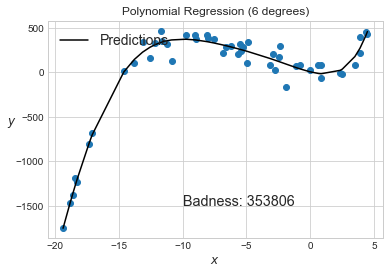

In [11]:
plt.scatter(x, y)    # plot data
plt.plot(x, poly, color = 'black', label = 'Predictions')    # plot polynomial
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$y$", rotation=0, fontsize=12)
plt.legend(loc="upper left", fontsize=14)
plt.text(-10, -1500, f'Badness: {int(badness_poly)}', fontsize = 'x-large')
plt.title(f'Polynomial Regression ({m} degrees)')

### 3) Genetic algorithm polynomial

We create 100 6-element arrays of random numbers. Each array is a chromosome and each chromosome has 5 genes. Each gene starts as a random number between -10 and 10.

In [173]:
# Initialization
num_of_chromosomes = 100
genes_per_chromosome = 6
chromosomes = np.random.uniform(low = -10, high = 10, size = (num_of_chromosomes, genes_per_chromosome))
chromosomes[0]

array([-2.78042425,  5.15837838,  2.56927566, -5.77539748,  9.26348722,
       -2.66962505])

The function below uses the `evaluate` function above to calculate the 'badness' or 'fitness' of the chromosome. It does this for all of the chromosomes and gathers the values into a list. This way the top 10 badness values can be found along with their corresponding chromosomes.

In [129]:
def create_badness_list(chromosomes):
    # chromosomes is the array of size 100x6 that holds 100 chromosomes of 6 genes each
    
    badness_list = []
    
    for i in range(num_of_chromosomes):
        genetic_coef = np.poly1d(chromosomes[i])    # create poly
        y_genetic = genetic_coef(x)    # get y-values from poly and x-values
        badness = evaluate(y, y_genetic)    # calc badness score
        badness_list.append(badness)
        
    return badness_list

The function below takes the top 10 offspring and uses one-point crossover to produce 90 new offspring. Starting with parent 0 and parent 1, the first half of parent 1's chromosomes and the second half of parent 2's chromosomes are taken and used to create an offspring. Then the same is done with parent 1 and parent 2 and this repeats until all 90 offspring have been repeated. If the last parent is reached it cycles back to parent 0. The rate is used to determine how often to conduct crossover - the higher the rate the more often it happen.

In [152]:
def crossover(parents, offspring_size, rate):
    # parents are the top 10 chromosomes
    # offspring_size is the number of offspring to produce, it is the number of total chromosomes (100) minus 10
    # rate is how often to conduct crossover for the given parents, it is a float between 0 and 1
    
    offspring = np.zeros(offspring_size)
    crossover_point = int(genes_per_chromosome / 2)    # middle of the chromosome
    
    for i in range(offspring_size[0]):
        random_num = np.random.uniform(0, 1)    # create random float between 0 and 1
        if float(random_num) > float(rate):    # if random float is greater than rate
            offspring[i] = parents[-1]    # don't do crossover and just assign last parent as offspring
            
        parent_1_idx = i % parents.shape[0]    # goes from parent 0 to 1 to 2 etc
        parent_2_idx = (i + 1) % parents.shape[0]    # goes from parents 1 to 2 to 3 etc
        offspring[i, 0:crossover_point] = parents[parent_1_idx, 0:crossover_point]    # first half of parent 1
        offspring[i, crossover_point:] = parents[parent_2_idx, crossover_point:]    # second half of parent 2
        
    return offspring

The function below takes the offspring from the crossover function and randomly mutates a gene in each. It does so by determining a random index and then multiplying the gene at that index by a random float between 0 and 2. The rate determines how often this happens.

In [153]:
def mutation(offspring_crossover, rate):
    # offspring_crossover is the offspring returned from the crossover operation
    # rate is how often to conduct mutation, it is a float between 0 and 1
    
    for i in range(offspring_crossover.shape[0]):
        random_num = np.random.uniform(0, 1)    # create random float between 0 and 1
        if float(random_num) > float(rate):    # if random float is greater than rate, skip this mutation
            continue
            
        random_idx = random.randrange(0, genes_per_chromosome - 1)    # get a random index of the chromosome
        random_value = np.random.uniform(0, 2)    # get a random float between 0 and 2
        offspring_crossover[i, random_idx] = offspring_crossover[i, random_idx] * random_value    # multiply the gene at the random index by the random float
        
    return offspring_crossover

Below is the main loop. It conducts crossover and mutation for many iterations with the hope that the badness score will decrease after each iteration.

In [174]:
# Main loop
best_badness_list = []    # list to hold all the badness values
for iteration in range(2500):
    # Create list of all the badness scores
    badness_list = create_badness_list(chromosomes)
    # Get index of the top 10 lowesst badness scores
    top_10_chromosomes_idx = sorted(range(len(badness_list)), key=lambda i: badness_list[i], reverse=True)[-10:]
    # Get lowest badness score
    best_badness = badness_list[top_10_chromosomes_idx[-1]]
    best_badness_list.append(best_badness)
    # Get chromosomes with the top 10 lowest badness scores
    top_10_chromosomes = np.zeros((10, genes_per_chromosome))
    for i, j in enumerate(top_10_chromosomes_idx):
        top_10_chromosomes[i] = chromosomes[j]
    # Make offspring with the top 10 chromosomes using one-point crossover
    offspring_crossover = crossover(top_10_chromosomes, (num_of_chromosomes - 10, genes_per_chromosome), 0.8)
    # Apply mutation to the offspring
    offspring_mutation = mutation(offspring_crossover, 0.1)
    # Combine parents and offspring
    new_chromosomes = np.zeros((num_of_chromosomes, genes_per_chromosome))
    new_chromosomes[0:10, :] = top_10_chromosomes
    new_chromosomes[10:, :] = offspring_mutation
    chromosomes = new_chromosomes

In [184]:
print(f'Badness - 1st Iteration:\t{best_badness_list[0]:.2f}')

Badness - 1st Iteration:	29406310783.99


In [183]:
print(f'Badness - Last Iteration:\t{best_badness_list[-1]:.2f}')

Badness - Last Iteration:	12156913.86


In [185]:
print(f'Best Chromosome:\n{top_10_chromosomes[-1]}')

Best Chromosome:
[ 2.32289004e-02  6.01725759e-01  2.99520975e+00 -7.38745566e+00
  1.13994106e-24 -9.05250943e+00]


In [186]:
y_genetic = np.poly1d(top_10_chromosomes[-1])

Text(0.5, 1.0, 'Genetic Algorithm - Polynomial')

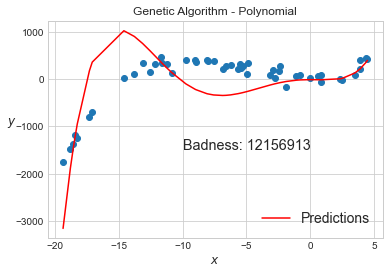

In [194]:
plt.scatter(x, y)
plt.plot(x, y_genetic(x), color = 'red', label = 'Predictions')
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$y$", rotation=0, fontsize=12)
plt.legend(loc="lower right", fontsize=14)
plt.text(-10, -1500, f'Badness: {int(best_badness_list[-1])}', fontsize = 'x-large')
plt.title('Genetic Algorithm - Polynomial')

Text(0.5, 1.0, 'Polynimal - Both Methods')

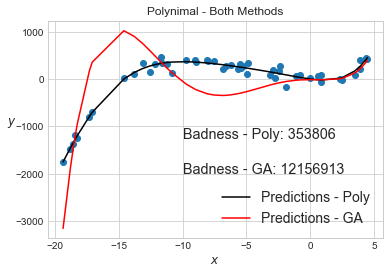

In [202]:
plt.scatter(x, y)    # plot data
plt.plot(x, poly, color = 'black', label = 'Predictions - Poly')    # plot polynomial
plt.plot(x, y_genetic(x), color = 'red', label = 'Predictions - GA')    # plot GA poly
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$y$", rotation=0, fontsize=12)
plt.legend(loc="lower right", fontsize=14)
plt.text(-10, -1250, f'Badness - Poly: {int(badness_poly)}', fontsize = 'x-large')
plt.text(-10, -2000, f'Badness - GA: {int(best_badness_list[-1])}', fontsize = 'x-large')
plt.title('Polynimal - Both Methods')

Above you can see a plot of the original noisy data, the polynomial obtained from the method in HW1, and the polynomial obtained using the genetic algorithm. Although the genetic algorithm does not produce a polynomial that fits the data quite as good as the original polynomial, it still managed to create a polynomial that fits the data surprisingly well with a decent badness score. 

This is impressive given the random nature of the algorithm, as by only conducting random crossover and mutations it was able to decrease the badness score from an 11 digit number to an 8 digit number (compared to the 6 digit number of the original polynomial). This goes to show that just by producing offspring using one-point crossover from the best parents of the current generation and adding in some random mutation, the algorithm is able to find a respectable solution.

Of note since this algorithm is random, different solution are obtained after every run. Running the algorithm multiple times produced both better and worse solutions. This means that it would be smart to run the algorithm several times and pick the best of the runs, similar to how other algorithms work like K-means clustering and GMM. Additionally, depending on the initial values of the genes and the crossover and mutation rate, better or worse solutions can be obtained, which is another reason to run the algorithm more than once, testing different values each time.

All and all we can confirm this algorithm works as intended by not only looking at the polynomial plots and the badness scores, but by also graphing the best badness scores over time to see if they decrease as intended, which they do as seen in the graph below (the first 15 are skipped so that the graph looks clearer as they are significantly higher than the rest).

Text(0, 0.5, 'Badness Score')

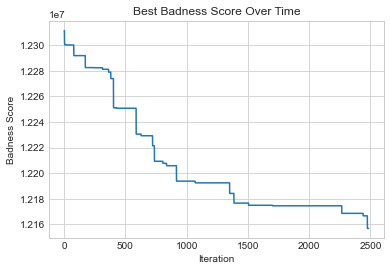

In [213]:
plt.plot(best_badness_list[15:])
plt.title('Best Badness Score Over Time')
plt.xlabel('Iteration')
plt.ylabel('Badness Score')